In [1]:
from pflow.particle_filter import BootstrapFilter, ObservationBase, FilterState, LikelihoodMethodBase, ProposalMethodBase
from pflow.base import BaseReweight
from pflow.optimal_transport.transportation_plan import Transport
from pflow.resampling.systematic import SystematicResampling
from pflow.optimal_transport.recentering import LearnBest, IncrementalLearning

In [2]:
import pykalman
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
class BrownianProposalMethod(ProposalMethodBase):
    def __init__(self, transition, lower_triang_chol):
        self.transition = transition
        locs = torch.zeros(lower_triang_chol.shape[0], requires_grad=False)
        self._dist = torch.distributions.MultivariateNormal(locs, scale_tril=lower_triang_chol)
        
    def apply(self, state, _observation):
        x = state.x
        sample = self._dist.rsample((x.shape[0],))
        x_proposed = ((self.transition @ state.x.T).T + sample)
        return FilterState(x=x_proposed, logw=state.logw, n=state.n, loglik=state.loglik)
    
class Observation(ObservationBase):
    __slots__ = ['y']
    def __init__(self, y):
        self.y = y
        
class LikelihoodMethod(LikelihoodMethodBase):
    def __init__(self, obs_matrix, obs_cov_triang):
        locs = torch.zeros(obs_cov_triang.shape[0], requires_grad=False)
        self._obs_matrix = obs_matrix
        self._dist = torch.distributions.MultivariateNormal(loc=locs, scale_tril=obs_cov_triang)
        
    def apply(self, state, observation, log=True):
        distance = (self._obs_matrix @ state.x.T).T - observation.y.unsqueeze(0)
        log_probs = self._dist.log_prob(distance)
        if log:
            return log_probs
        else:
            return log_probs.exp()
        
class NoResampling(BaseReweight):
    def apply(self, x, w, logw):
        return x, logw

In [4]:
_ = torch.random.manual_seed(0)

In [5]:
import math
import random
random.seed(42)

In [6]:
def generate_sine(dt, seed=42, observation_error=1):
    random.seed(seed)
    t = 0
    while True:
        yield math.sin(t) + observation_error * random.gauss(0., 1.), math.cos(t) + observation_error * random.gauss(0., 1.)
        t += dt

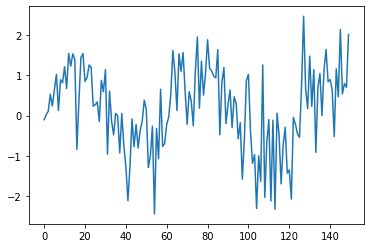

In [7]:
dt = 0.1
K = 150

sine_gen = generate_sine(dt, 42, 0.7)
sine = [[next(sine_gen)[0]] for _ in range(K)]
observations = np.asanyarray(sine)
plt.plot(observations)

In [8]:


def run_pf(flat, log_sigma, dt_init, epsilon=0.5, n=100, seed=0, scaling=0.75, reach=None, min_neff=0.5, reweighting_method=None):
    states = []
    observations = []
    
    torch.random.manual_seed(seed)
    
    initial_dist = torch.distributions.MultivariateNormal(torch.tensor([0., 1.]), scale_tril=torch.tensor([[1., 0.], [0., 1.]]))
    initial_x = initial_dist.rsample((n,)).clone()
    initial_x.requires_grad=True
    initial_w = torch.full((n,), 1/n, requires_grad=True)
    initial_log_lik = torch.tensor(0., requires_grad=True)
    
    lower = torch.zeros((2, 2), requires_grad=False)
    tril_indices = torch.tril_indices(row=2, col=2, offset=0)
    lower[tril_indices[0], tril_indices[1]] = flat
    
    transition_matrix = torch.tensor([[1., 0.], [0., 1.]])
    transition_matrix[0, 1] = dt_init
    transition_matrix[1, 0] = -dt_init

    sigma = log_sigma.exp()
    obs_triang = torch.eye(1, requires_grad=False) * sigma
    obs_matrix = torch.tensor([[1., 0.]], requires_grad=False)
    state = FilterState(x=initial_x, logw=initial_w.log(), n=n, loglik=initial_log_lik)
    likelihood_method = LikelihoodMethod(obs_matrix, obs_triang)
    if reweighting_method is None:
        if epsilon > 0:
            reweighting_method = Transport(epsilon=epsilon, scaling=scaling, reach=reach)
        else:
            reweighting_method = SystematicResampling()
    boot = BootstrapFilter(proposal_method=BrownianProposalMethod(transition_matrix, lower),
                           likelihood_method=likelihood_method, 
                           reweighting_method=reweighting_method,
                           min_neff=min_neff)
    n_obs = 0
    for val in sine:
        n_obs += 1
        obs = Observation(torch.tensor(val, requires_grad=False))
        state = boot.update(state, obs)
        observations.append(obs)
        states.append(state)
        
        state = boot.predict(state, None)
    return -state.loglik / n_obs, states, observations

In [9]:
log_sigma = torch.tensor(math.log(0.5)/2, requires_grad=True)
flat = torch.tensor([math.sqrt(0.05), 0., math.sqrt(0.05)], requires_grad=True)
dt_tensor = torch.tensor(dt, requires_grad=False)


In [10]:

res_0_1 = run_pf(flat, log_sigma, dt_tensor, 0.25, n=100, scaling=0.75, min_neff=0.5, reach=2.)
print('done')
res_1_0 = run_pf(flat, log_sigma, dt_tensor, 1., n=100, scaling=0.75, min_neff=0.5, reach=2.)
print('done')
# res_learnt = run_pf(flat, log_sigma, dt_tensor, None, reweighting_method=LearnBest(0.1, {'scaling': 0.5, 'reach': 5.}, {'lr': 1.}, n_steps=10), n=100, min_neff=0.5)
# print('done')
res_systematic = run_pf(flat, log_sigma, dt_tensor, 0., n=100, min_neff=0.5)
print('done')
res_no_resampling = run_pf(flat, log_sigma, dt_tensor, None, reweighting_method=NoResampling(), n=100)

done
done
done


In [11]:
seeds = np.arange(0, 10).astype(int)
xs = np.linspace(0.5, 0.75, 10)
epsilons = [0.5, 0.75, 1.]

In [12]:
np.exp(5)

148.4131591025766

In [13]:
# gradient_list_ot = np.empty((len(epsilons), len(xs)))
# ll_list_ot = np.empty((len(epsilons), len(xs)))
# for i in range(len(epsilons)):
#     eps = epsilons[i]
#     for j in tqdm.trange(len(xs)):
#         min_neff = xs[j]
#         test_res = run_pf(flat, log_sigma, dt_tensor, eps, n=100, scaling=0.95, min_neff=min_neff, seed=42, reach=1.)
#         ll = test_res[0]
#         grad = torch.autograd.grad(ll, log_sigma)[0].numpy().sum()
#         ll_list_ot[i, j] = ll
#         gradient_list_ot[i, j] = grad

In [14]:
# gradient_list_sys = np.empty((len(seeds), len(xs)))
# ll_list_sys = np.empty((len(seeds), len(xs)))
# for i in tqdm.trange(len(seeds)):
#     seed = seeds[i]
#     for j in range(len(xs)):
#         min_neff = xs[j]
#         test_res = run_pf(flat, log_sigma, dt_tensor, 0., n=100, min_neff=min_neff, seed=seed)
#         ll = test_res[0]
#         grad = torch.autograd.grad(ll, log_sigma)[0].numpy().sum()
#         ll_list_sys[i, j] = ll
#         gradient_list_sys[i, j] = grad

In [15]:
kf1 = pykalman.KalmanFilter(observation_covariance=[[0.5]], 
                            transition_covariance=[[0.05, 0.],
                                                       [0., 0.05]], 
                            transition_matrices=[[1., dt], 
                                                 [-dt, 1.]], 
                            initial_state_mean=[0., 1.])
kf2 = pykalman.KalmanFilter(observation_covariance=[[np.exp(math.log(0.5) + 2e-3)]], 
                                transition_covariance=[[0.05, 0.],
                                                       [0., 0.05]], 
                            transition_matrices=[[1., dt], 
                                                 [-dt, 1.]], 
                            initial_state_mean=[0., 1.])

In [16]:
exact_filter = kf1.filter(observations)

In [17]:
ll1 = -kf1.loglikelihood(observations) / K
ll2 = -kf2.loglikelihood(observations) / K
real_gradient = 1e3*(ll2-ll1)

In [18]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey='row')

# for ax in axes[-1, :].flatten():
#     ax.set_xlabel('minimum ESS (%)')
    
# axes[0, 0].set_ylabel('-loglikelihood')
# axes[0, 0].set_title(r'$OT_{\epsilon}$ resampling')
# axes[0, 1].set_title(r'Systematic resampling')
# axes[1, 0].set_ylabel(r'$-\nabla$ loglikelihood')
    
# for ax in axes[0, :].flatten():
#     ax.plot(xs, [ll1]*len(xs), linestyle='--', label = 'Theoretical log-likelihood', color='k')
    
# for ax in axes[1, :].flatten():
#     ax.plot(xs, [real_gradient]*len(xs), linestyle='--', label = 'Theoretical gradient', color='k')
    
# for eps, ll_ot in zip(epsilons, ll_list_ot):
#     axes[0, 0].plot(xs, ll_ot, label=f'EPS: {eps}')

# axes[0, 1].plot(xs, ll_list_sys.mean(axis=0), label='systematic resampling')
# axes[0, 1].fill_between(xs, 
#                         ll_list_sys.mean(axis=0) - 2 * ll_list_sys.std(axis=0),
#                         ll_list_sys.mean(axis=0) + 2 * ll_list_sys.std(axis=0), alpha = 0.3)
    
# for eps, grad_ot in zip(epsilons, gradient_list_ot):
#     axes[1, 0].plot(xs, grad_ot, label=f'EPS: {eps}')

# axes[1, 1].plot(xs, gradient_list_sys.mean(axis=0), label='systematic resampling')
# axes[1, 1].fill_between(xs, 
#                         gradient_list_sys.mean(axis=0) - 2 * gradient_list_sys.std(axis=0),
#                         gradient_list_sys.mean(axis=0) + 2 * gradient_list_sys.std(axis=0), alpha = 0.3)
# axes[1, 0].legend()

# fig.savefig('loglik_gradient.png')

In [19]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights, axis=0)
    return (average, np.sqrt(variance))

In [20]:
def plot_pf_component(pf_res, component, ax, label):
    pf_state, pf_weight = zip(*[(l.x.detach().cpu().numpy(),  l.w.detach().cpu().numpy()) for l in pf_res[1]])
    pf_weight = np.stack(pf_weight, axis=0)
    pf_state = np.stack(pf_state, axis=0)

    pf_mean, pf_std = weighted_avg_and_std(pf_state[:, :, component].T,  pf_weight.T)
    ax.plot(linspace, pf_mean, label = label)
    ax.fill_between(linspace, 
                    pf_mean - 2 * pf_std,
                    pf_mean + 2 * pf_std, alpha = 0.3)
    

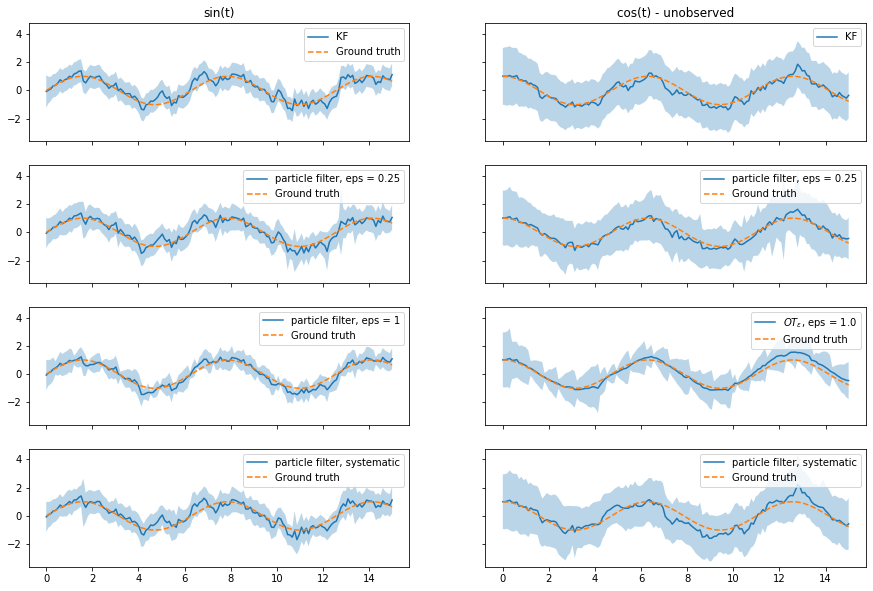

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.T
linspace = np.linspace(0., dt * K, K)

axes[0, 0].plot(linspace, exact_filter[0][:, 0].squeeze(), label='KF')
axes[0, 0].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')
axes[0, 0].fill_between(linspace, 
                        exact_filter[0][:, 0].squeeze() - 2*np.sqrt(exact_filter[1][:, 0, 0]),
                        exact_filter[0][:, 0].squeeze() + 2*np.sqrt(exact_filter[1][:, 0, 0]), alpha = 0.3)

axes[1, 0].plot(linspace, exact_filter[0][:, 1].squeeze(), label='KF')
axes[1, 0].plot(linspace, np.cos(linspace), linestyle = '--')
axes[1, 0].fill_between(linspace, 
                        exact_filter[0][:, 1].squeeze() - 2*np.sqrt(exact_filter[1][:, 1, 1]),
                        exact_filter[0][:, 1].squeeze() + 2*np.sqrt(exact_filter[1][:, 1, 1]), alpha = 0.3)

# sin
plot_pf_component(res_0_1, 0, axes[0, 1], 'particle filter, eps = 0.25')
axes[0, 1].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')

plot_pf_component(res_1_0, 0, axes[0, 2], 'particle filter, eps = 1')
axes[0, 2].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')

# plot_pf_component(res_learnt, 0, axes[0, 3], 'particle filter, learnt')
# axes[0, 3].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')

plot_pf_component(res_systematic, 0, axes[0, 3], 'particle filter, systematic')
axes[0, 3].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')

# plot_pf_component(res_no_resampling, 0, axes[0, 5], 'particle filter, no resampling')
# axes[0, 5].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')

# cos
plot_pf_component(res_0_1, 1, axes[1, 1], 'particle filter, eps = 0.25')
axes[1, 1].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')

plot_pf_component(res_1_0, 1, axes[1, 2], '$OT_\epsilon$, eps = 1.0')
axes[1, 2].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')

# plot_pf_component(res_learnt, 1, axes[1, 3], 'particle filter, learnt')
# axes[1, 3].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')

plot_pf_component(res_systematic, 1, axes[1, 3], 'particle filter, systematic')
axes[1, 3].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')

# plot_pf_component(res_no_resampling, 1, axes[1, 5], 'particle filter, no resampling')
# axes[1, 5].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')



for ax in axes.flatten():
    ax.legend(loc='upper right')

axes[0, 0].set_title('sin(t)')
_ = axes[1, 0].set_title('cos(t) - unobserved')

fig.savefig('KF_OptimalTransportPF_comp.png')

In [22]:
linspace = np.linspace(0.25, 0.75, 400)

In [23]:
results_for_smoothness_ot_dict = {}
results_for_smoothness_ot_grad_dict = {}
for eps in [0.5, 0.75, 1.]:
    results_for_smoothness_ot_dict[eps] = []
    results_for_smoothness_ot_grad_dict[eps] = []
    for val in tqdm.tqdm(linspace):
        log_sigma_val = torch.tensor(math.log(val)/2, requires_grad=True)
#         with torch.autograd.detect_anomaly():
        temp_res = run_pf(flat, log_sigma_val, dt_tensor, eps, n=100, scaling=0.9, min_neff=0.5, reach=5.)
        results_for_smoothness_ot_grad_dict[eps].append(torch.autograd.grad(temp_res[0], log_sigma_val)[0].detach().cpu().numpy())
        results_for_smoothness_ot_dict[eps].append(temp_res[0].detach().cpu().numpy())
    


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:45<00:00,  2.58it/s]


In [25]:
results_for_smoothness_systematic_dict = {}
results_for_smoothness_systematic_grad_dict = {}
for n in [100]:
    results_for_smoothness_systematic_dict[n] = []
    results_for_smoothness_systematic_grad_dict[n] = []
    for val in tqdm.tqdm(linspace):
        log_sigma_val = torch.tensor(math.log(val)/2, requires_grad=True)
        temp_res = run_pf(flat, log_sigma_val, dt_tensor, 0., n=n)
        results_for_smoothness_systematic_grad_dict[n].append(torch.autograd.grad(temp_res[0], log_sigma_val)[0].detach().cpu().numpy())
        results_for_smoothness_systematic_dict[n].append(temp_res[0].detach().cpu().numpy())


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:02<00:00,  5.89it/s]


In [26]:
# results_for_learnt_ot_dict = {}
# eps = 0.1
# adam_kwargs = {'lr': 0.5}
# methods = {#'incremental': IncrementalLearning(eps, {'scaling': 0.5}, adam_kwargs, 4, 5),
#            'one-shot': LearnBest(eps, {'scaling': 0.75}, adam_kwargs, 10)}
# for name, method in methods.items():
#     results_for_learnt_ot_dict[name] = [~]
#     for val in tqdm.tqdm(linspace):
#         log_sigma_tensor = torch.tensor(val, requires_grad=False)
#         temp_res = run_pf(flat, log_sigma_tensor, dt_tensor, eps, n=250, reweighting_method=method)
#         results_for_learnt_ot_dict[name].append(temp_res[0].detach().cpu().numpy())


In [27]:
results_for_kalman = []
grads_for_kalman = []
for val in tqdm.tqdm(linspace):
    kf = pykalman.KalmanFilter(observation_covariance=[[val]], 
                               transition_covariance=[[0.05, 0.],
                                                       [0., 0.05]], 
                                transition_matrices=[[1., dt], 
                                                     [-dt, 1.]], 
                                observation_matrices=np.array([[1., 0.]]), 
                                initial_state_mean=np.array([0., 1.]), 
                                initial_state_covariance=np.eye(2))
    kf_eps = pykalman.KalmanFilter(observation_covariance=[[math.exp(math.log(val)+2e-4)]], 
                                   transition_covariance=[[0.05, 0.],
                                                           [0., 0.05]], 
                                    transition_matrices=[[1., dt], 
                                                         [-dt, 1.]], 
                                    observation_matrices=np.array([[1., 0.]]), 
                                    initial_state_mean=np.array([0., 1.]), 
                                    initial_state_covariance=np.eye(2))
    ll = -kf.loglikelihood(observations)/K
    ll_eps = -kf_eps.loglikelihood(observations)/K
    results_for_kalman.append(ll)
    grads_for_kalman.append(1e4*(ll_eps-ll))

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:09<00:00,  6.03it/s]


In [28]:
def plot_gradient(linspace, values, gradients, k, ax, line):
    x = np.take(linspace, k)
    y = np.take(values, k)
    v = np.take(gradients, k)
    u = [1]*len(k)
    ax.quiver(x, y, u, v, scale=20, zorder=3, color=l.get_color(),
          width=0.007, headwidth=3., headlength=4.)

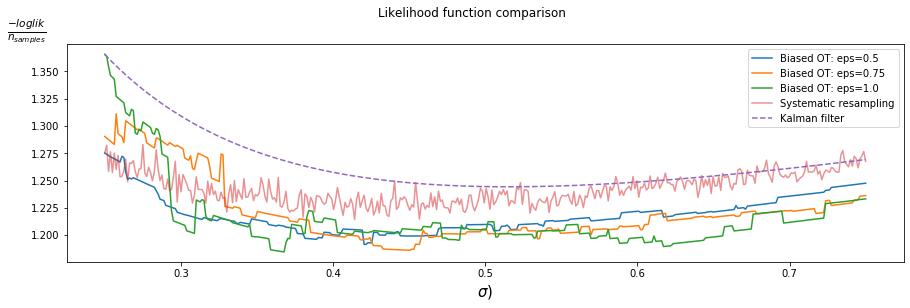

In [37]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4), sharey=False, sharex=False)
fig.suptitle('Likelihood function comparison', y = 1.01)

for eps, lst in results_for_smoothness_ot_dict.items():
    ax.plot(linspace, lst, label=f'Biased OT: eps={eps}')
ax.plot(linspace, results_for_smoothness_systematic_dict[100], label=f'Systematic resampling', alpha=0.5)
ax.plot(linspace, results_for_kalman, label = 'Kalman filter', linestyle = '--')

# zoom = slice(0, 250)
# grads_locs =  [25, 100, 175]
# for eps, lst in results_for_smoothness_ot_dict.items():
#     l, = axes[1].plot(linspace[zoom], lst[zoom], label=f'Biased OT: eps={eps}')
#     plot_gradient(linspace, lst, results_for_smoothness_ot_grad_dict[eps], grads_locs, axes[1], l)

# l, = axes[1].plot(linspace[zoom], results_for_smoothness_systematic_dict[100][zoom], label=f'Systematic resampling', alpha=0.5)
# plot_gradient(linspace, results_for_smoothness_systematic_dict[100], results_for_smoothness_systematic_grad_dict[100], grads_locs, axes[1], l)

# axes[1].plot(linspace[zoom], results_for_kalman[zoom], label = 'Kalman filter', linestyle = '--')

# for ax in axes.flatten():
ax.set_ylabel('$\\frac{-loglik}{n_{samples}}$', rotation=0, y=1, fontsize=15)
ax.set_xlabel('$\sigma)$', rotation=0, y=1, fontsize=15)
    
ax.legend()
    
fig.savefig('likelihood.png')

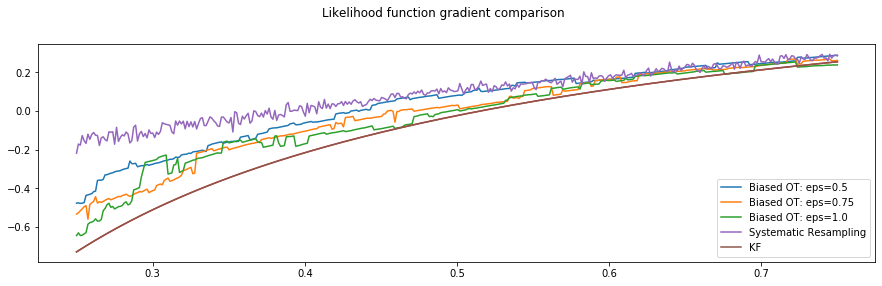

In [32]:
fig, ax = plt.subplots(figsize=(15, 4), sharey=False, sharex=True)
fig.suptitle('Likelihood function gradient comparison', y = 1.01)
for eps, grads in results_for_smoothness_ot_grad_dict.items():
    ax.plot(linspace, np.stack(grads), label = f'Biased OT: eps={eps}')
    
ax.plot(linspace, np.stack(grads_for_kalman))

ax.plot(linspace, np.stack(results_for_smoothness_systematic_grad_dict[100]), label='Systematic Resampling')
ax.plot(linspace, np.stack(grads_for_kalman), label='KF')

ax.legend()
fig.savefig('likelihoodGradient.png')

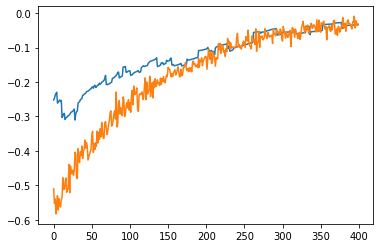

In [38]:
plt.plot(np.stack(grads_for_kalman) - np.stack(results_for_smoothness_ot_grad_dict[0.5]))
plt.plot(np.stack(grads_for_kalman) - np.stack(results_for_smoothness_systematic_grad_dict[100]))